In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from pathlib import Path
from time import time
from collections import deque
from random import sample

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import gym
from gym.envs.registration import register

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

np.random.seed(42)
tf.random.set_seed(42)
sns.set_style('whitegrid')

results_path = Path('results', 'trading_bot')
if not results_path.exists():
    results_path.mkdir(parents=True)

Using CPU


In [3]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return '{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s)

In [4]:
# Set up Gym Environment

trading_days = 252
register( id='trading-v0', entry_point='trading_env:TradingEnvironment', max_episode_steps=trading_days )

In [5]:
# Initialize Trading Environment
trading_cost_bps = 1e-3
time_cost_bps = 1e-4
print(f'Trading costs: {trading_cost_bps:.2%} | Time costs: {time_cost_bps:.2%}')

Trading costs: 0.10% | Time costs: 0.01%


In [6]:
trading_environment = gym.make('trading-v0', ticker='AAPL', trading_days=trading_days,
                               trading_cost_bps=trading_cost_bps, time_cost_bps=time_cost_bps)
trading_environment.seed(42)

INFO:trading_env:trading_env logger started.
INFO:trading_env:loading data for AAPL...
INFO:trading_env:got data for AAPL...
INFO:trading_env:None


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9367 entries, (Timestamp('1981-01-30 00:00:00'), 'AAPL') to (Timestamp('2018-03-27 00:00:00'), 'AAPL')
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  9367 non-null   float64
 1   ret_2    9367 non-null   float64
 2   ret_5    9367 non-null   float64
 3   ret_10   9367 non-null   float64
 4   ret_21   9367 non-null   float64
 5   rsi      9367 non-null   float64
 6   macd     9367 non-null   float64
 7   atr      9367 non-null   float64
 8   stoch    9367 non-null   float64
 9   ultosc   9367 non-null   float64
dtypes: float64(10)
memory usage: 1.5+ MB


[42]

In [18]:
trading_environment.tail(10)

AttributeError: 'TradingEnvironment' object has no attribute 'tail'

In [7]:
# Get Environment Params
state_dim = trading_environment.observation_space.shape[0]
num_actions = trading_environment.action_space.n
max_episode_steps = trading_environment.spec.max_episode_steps

In [8]:
# Define Trading Agent
class DDQNAgent:
    def __init__(self, state_dim, num_actions, learning_rate, gamma, epsilon_start, epsilon_end,
                 epsilon_decay_steps, epsilon_exponential_decay, replay_capacity, architecture, l2_reg,
                 tau, batch_size):

        self.state_dim = state_dim
        self.num_actions = num_actions
        self.experience = deque([], maxlen=replay_capacity)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.architecture = architecture
        self.l2_reg = l2_reg

        self.online_network = self.build_model()
        self.target_network = self.build_model(trainable=False)
        self.update_target()

        self.epsilon = epsilon_start
        self.epsilon_decay_steps = epsilon_decay_steps
        self.epsilon_decay = (epsilon_start - epsilon_end) / epsilon_decay_steps
        self.epsilon_exponential_decay = epsilon_exponential_decay
        self.epsilon_history = []

        self.total_steps = self.train_steps = 0
        self.episodes = self.episode_length = self.train_episodes = 0
        self.steps_per_episode = []
        self.episode_reward = 0
        self.rewards_history = []

        self.batch_size = batch_size
        self.tau = tau
        self.losses = []
        self.idx = tf.range(batch_size)
        self.train = True

    def build_model(self, trainable=True):
        layers = []
        n = len(self.architecture)
        for i, units in enumerate(self.architecture, 1):
            layers.append(Dense(units=units, input_dim=self.state_dim if i == 1 else None, activation='relu', kernel_regularizer=l2(self.l2_reg), name=f'Dense_{i}', trainable=trainable))
        layers.append(Dropout(.1))
        layers.append(Dense(units=self.num_actions, trainable=trainable, name='Output'))
        model = Sequential(layers)
        model.compile(loss='mean_squared_error', optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target(self):
        self.target_network.set_weights(self.online_network.get_weights())

    def epsilon_greedy_policy(self, state):
        self.total_steps += 1
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.num_actions)
        q = self.online_network.predict(state)
        return np.argmax(q, axis=1).squeeze()

    def memorize_transition(self, s, a, r, s_prime, not_done):
        if not_done:
            self.episode_reward += r
            self.episode_length += 1
        else:
            if self.train:
                if self.episodes < self.epsilon_decay_steps:
                    self.epsilon -= self.epsilon_decay
                else:
                    self.epsilon *= self.epsilon_exponential_decay

            self.episodes += 1
            self.rewards_history.append(self.episode_reward)
            self.steps_per_episode.append(self.episode_length)
            self.episode_reward, self.episode_length = 0, 0

        self.experience.append((s, a, r, s_prime, not_done))

    def experience_replay(self):
        if self.batch_size > len(self.experience):
            return
        minibatch = map(np.array, zip(*sample(self.experience, self.batch_size)))
        states, actions, rewards, next_states, not_done = minibatch

        next_q_values = self.online_network.predict_on_batch(next_states)
        best_actions = tf.argmax(next_q_values, axis=1)

        next_q_values_target = self.target_network.predict_on_batch(next_states)
        target_q_values = tf.gather_nd(next_q_values_target,
                                       tf.stack((self.idx, tf.cast(best_actions, tf.int32)), axis=1))

        targets = rewards + not_done * self.gamma * target_q_values

        q_values = self.online_network.predict_on_batch(states)
        q_values[[self.idx, actions]] = targets

        loss = self.online_network.train_on_batch(x=states, y=q_values)
        self.losses.append(loss)

        if self.total_steps % self.tau == 0:
            self.update_target()

In [9]:
# Define hyperparameters
gamma = .99,  # discount factor
tau = 100  # target network update frequency

# NN Architecture
architecture = (256, 256)  # units per layer
learning_rate = 0.0001  # learning rate
l2_reg = 1e-6  # L2 regularization

# Experience Replay
replay_capacity = int(1e6)
batch_size = 4096

# e?-greedy Policy
epsilon_start = 1.0
epsilon_end = .01
epsilon_decay_steps = 250
epsilon_exponential_decay = .99

In [10]:
# Create DDQN Agent
tf.keras.backend.clear_session()
ddqn = DDQNAgent(state_dim=state_dim, num_actions=num_actions, learning_rate=learning_rate, gamma=gamma,
                 epsilon_start=epsilon_start, epsilon_end=epsilon_end, epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay, replay_capacity=replay_capacity,
                 architecture=architecture, l2_reg=l2_reg, tau=tau, batch_size=batch_size)
ddqn.online_network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_1 (Dense)              (None, 256)               2816      
_________________________________________________________________
Dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
Output (Dense)               (None, 3)                 771       
Total params: 69,379
Trainable params: 69,379
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Run Experiment

# Set parameters
total_steps = 0
max_episodes = 1000

# Initialize variables
episode_time, navs, market_navs, diffs, episode_eps = [], [], [], [], []

# Visualization
def track_results(episode, nav_ma_100, nav_ma_10, market_nav_100, market_nav_10,
                  win_ratio, total, epsilon):
    time_ma = np.mean([episode_time[-100:]])
    T = np.sum(episode_time)

    template = '{:>4d} | {} | Agent: {:>6.1%} ({:>6.1%}) | Market: {:>6.1%} ({:>6.1%}) | '
    template += 'Wins: {:>5.1%} | eps: {:>6.3f}'
    print(template.format(episode, format_time(total), nav_ma_100-1, nav_ma_10-1,
                          market_nav_100-1, market_nav_10-1, win_ratio, epsilon))

In [12]:
# Train Agent
start = time()
results = []
for episode in range(1, max_episodes + 1):
    this_state = trading_environment.reset()
    for episode_step in range(max_episode_steps):
        action = ddqn.epsilon_greedy_policy(this_state.reshape(-1, state_dim))
        next_state, reward, done, _ = trading_environment.step(action)

        ddqn.memorize_transition(this_state, action, reward, next_state, 0.0 if done else 1.0)
        if ddqn.train:
            ddqn.experience_replay()
        if done:
            break
        this_state = next_state

    # get DataFrame with seqence of actions, returns and nav values
    result = trading_environment.env.simulator.result()

    # get results of last step
    final = result.iloc[-1]

    # apply return (net of cost) of last action to last starting nav
    nav = final.nav * (1 + final.strategy_return)
    navs.append(nav)

    # market nav
    market_nav = final.market_nav
    market_navs.append(market_nav)

    # track difference between agent an market NAV results
    diff = nav - market_nav
    diffs.append(diff)

    if episode % 10 == 0:
        track_results(episode,
                      # show mov. average results for 100 (10) periods
                      np.mean(navs[-100:]), np.mean(navs[-10:]),
                      np.mean(market_navs[-100:]), np.mean(market_navs[-10:]),
                      # share of agent wins, defined as higher ending nav
                      np.sum([s > 0 for s in diffs[-100:]])/min(len(diffs), 100), time() - start, ddqn.epsilon)
    if len(diffs) > 25 and all([r > 0 for r in diffs[-25:]]):
        print(result.tail())
        break

trading_environment.close()

  10 | 00:00:04 | Agent: -39.0% (-39.0%) | Market:   4.6% (  4.6%) | Wins: 20.0% | eps:  0.960
  20 | 00:01:20 | Agent: -35.1% (-31.3%) | Market:  23.2% ( 41.8%) | Wins: 20.0% | eps:  0.921
  30 | 00:04:35 | Agent: -28.8% (-16.2%) | Market:  20.6% ( 15.4%) | Wins: 20.0% | eps:  0.881
  40 | 00:07:54 | Agent: -24.6% (-12.0%) | Market:  21.2% ( 23.0%) | Wins: 22.5% | eps:  0.842
  50 | 00:11:18 | Agent: -23.3% (-17.9%) | Market:  20.2% ( 16.4%) | Wins: 22.0% | eps:  0.802
  60 | 00:14:49 | Agent: -24.7% (-32.0%) | Market:  24.5% ( 45.6%) | Wins: 21.7% | eps:  0.762
  70 | 00:18:24 | Agent: -24.1% (-20.6%) | Market:  29.4% ( 59.3%) | Wins: 21.4% | eps:  0.723
  80 | 00:22:03 | Agent: -25.2% (-32.7%) | Market:  27.6% ( 14.7%) | Wins: 21.2% | eps:  0.683
  90 | 00:25:49 | Agent: -25.0% (-23.7%) | Market:  24.3% ( -2.1%) | Wins: 23.3% | eps:  0.644
 100 | 00:29:37 | Agent: -25.3% (-28.0%) | Market:  24.0% ( 20.9%) | Wins: 23.0% | eps:  0.604
 110 | 00:33:42 | Agent: -24.2% (-27.5%) | Market:

In [13]:
# Store Results
results = pd.DataFrame({'Episode': list(range(1, episode+1)), 'Agent': navs, 'Market': market_navs,
                        'Difference': diffs}).set_index('Episode')

results['Strategy Wins (%)'] = (results.Difference > 0).rolling(100).sum()
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agent              1000 non-null   float64
 1   Market             1000 non-null   float64
 2   Difference         1000 non-null   float64
 3   Strategy Wins (%)  901 non-null    float64
dtypes: float64(4)
memory usage: 39.1 KB


In [14]:
results.to_csv(results_path / 'results.csv', index=False)

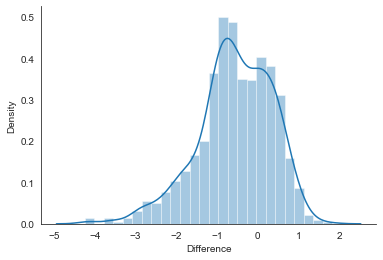

In [15]:
with sns.axes_style('white'):
    sns.distplot(results.Difference)
    sns.despine()

In [16]:
# Evaluate Results
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agent              1000 non-null   float64
 1   Market             1000 non-null   float64
 2   Difference         1000 non-null   float64
 3   Strategy Wins (%)  901 non-null    float64
dtypes: float64(4)
memory usage: 39.1 KB


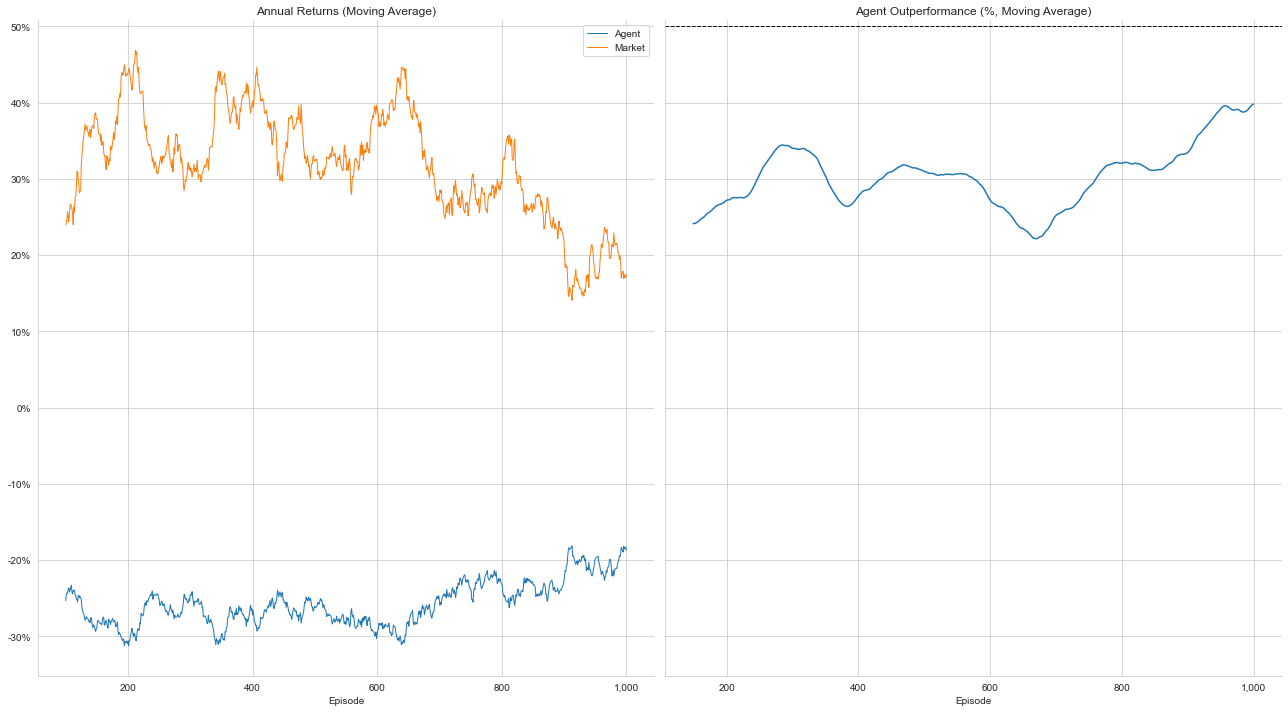

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 10), sharey=True)

df1 = (results[['Agent', 'Market']].sub(1).rolling(100).mean())
df1.plot(ax=axes[0], title='Annual Returns (Moving Average)', lw=1)

df2 = results['Strategy Wins (%)'].div(100).rolling(50).mean()
df2.plot(ax=axes[1], title='Agent Outperformance (%, Moving Average)')

for ax in axes:
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
axes[1].axhline(.5, ls='--', c='k', lw=1)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'performance', dpi=300)